##### Imports 

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp 
import scipy.sparse.linalg as spla
from tqdm import tqdm

#### Functions 

In [333]:
def Enforce_Simple_Boundary(Nodes, nx_d2, T_in=100.0, T_out=0.0):
    '''
    Enforce heat in/out at top, and boundaries insulated.
    
    INPUTS
    Nodes (array) : All node temperatures for the plate
    nx_d2 (int) : nx/2, number of x nodes divided by two
    T_in (float) : Temperature of heat inlet
    T_out (float) : Temperature of heat outlet
    
    OUTPUTS
    Nodes (array) : Node temperatures with boundary enforced
    '''
    # Make sure the left half of the top is T_in
    Nodes[:nx_d2, 0] = T_in
    
    # Make sure the right half of the top is T_out
    Nodes[nx_d2:, 0] = T_out
    
    # Make sure sides are insulated
    Nodes[0, 1:-1] = Nodes[1, 1:-1]     # left boundary
    Nodes[-1, 1:-1] = Nodes[-2, 1:-1]   # right boundary
    Nodes[1:-1, -1] = Nodes[1:-1, -2]   # bottom boundary
    
    return Nodes

In [334]:
def Enforce_Complex_Boundary(Nodes, nx_d2, 
                             hole_start_x=75, hole_start_y=25,
                             hole_end_x=125, hole_end_y=75,
                             T_in=100.0, T_out=0.0):
    '''
    Enforce heat in/out at top, and boundaries insulated. Hole in the middle.
    
    INPUTS
    Nodes (array) : All node temperatures for the plate, with 0,0 being top left
    nx_d2 (int) : nx/2, number of x nodes divided by two
    hole_start_x (int) : First hole node in x
    hole_start_y (int) : First hole node in y
    hole_end_x (int) : Last hole node in x
    hole_end_y (int) : Last hole node in y
    T_in (float) : Temperature of heat inlet
    T_out (float) : Temperature of heat outlet
    
    OUTPUTS
    Nodes (array) : Node temperatures with boundary enforced
    '''
    # Make sure the left half of the top is T_in
    Nodes[:nx_d2, 0] = T_in
    
    # Make sure the right half of the top is T_out
    Nodes[nx_d2:, 0] = T_out
    
    # Make sure sides are insulated
    Nodes[0, 1:-1] = Nodes[1, 1:-1]     # left boundary
    Nodes[-1, 1:-1] = Nodes[-2, 1:-1]   # right boundary
    Nodes[1:-1, -1] = Nodes[1:-1, -2]   # bottom boundary
    
    # Hole insulation
    Nodes[hole_start_x, hole_start_y:hole_end_y] = Nodes[hole_start_x-1, hole_start_y:hole_end_y]    # left boundary
    Nodes[hole_end_x-1, hole_start_y:hole_end_y] = Nodes[hole_end_x, hole_start_y:hole_end_y]    # right boundary
    Nodes[hole_start_x:hole_end_x, hole_end_y-1] = Nodes[hole_start_x:hole_end_x, hole_end_y]    # bottom boundary
    Nodes[hole_start_x:hole_end_x, hole_start_y] = Nodes[hole_start_x:hole_end_x, hole_start_y-1]    # top
    
    # Temp in hole stays 0
    Nodes[hole_start_x:hole_end_x, hole_start_y:hole_end_y] = 0.0
    
    return Nodes

In [335]:
def Implicit_Timestep(Nodes, Coeff_Mat, nx, ny, boundary_func):
    '''
    Propogate implicit heat transfer simulation for one timestep using a solver. 
    
    INPUTS
    Nodes (array) : Node temperatures at current timestep
    Coeff_Mat (array) : Coefficient matrix for implicit solver
    nx (int) : Number of x nodes
    ny (int) : Number of y nodes
    boundary_func (func) : function to enforce boundary conditions
    
    OUTPUTS
    New_Nodes (array) : Node temperatures at next timestep
    '''
    # Flatten the nodes array so that we may pass it to the solver
    Nodes_flat = Nodes.flatten()
    
    # Work out next timestep using solver
    New_Nodes_flat = spla.spsolve(Coeff_Mat, Nodes_flat)
    
    # Reshape and apply boundary conditions 
    New_Nodes = New_Nodes_flat.reshape((nx+2, ny+2))
    New_Nodes = boundary_func(New_Nodes, int(nx/2))
    
    return New_Nodes

#### Test System 

In [373]:
# Set parameters
Lx, Ly = 2, 1    # Lenghts 
nx, ny = 200, 100    # Number of nodes   
dx, dy = Lx/nx, Ly/ny    # Node size

t = 2e6    # Total simulation time
nt = 500    # Number of timesteps
dt = t/nt

k = 0.025
rho = 1.225
c_p = 1005
alpha = k/(rho*c_p)


# Define the coefficient matrix for implicit solver
# Coefficient for x and y directions
cx = alpha * dt / (dx**2)
cy = alpha * dt / (dy**2)

# Create diagonal matrices
diagonals_x = [-cx, 1 + 2*cx, -cx]
diagonals_y = [-cy, 1 + 2*cy, -cy]

# Create 1D matrices
Ax = sp.diags(diagonals_x, [-1, 0, 1], shape=(nx+2, nx+2))
Ay = sp.diags(diagonals_y, [-1, 0, 1], shape=(ny+2, ny+2))

# Use Kronecker product to create 2D matrix
# Note: Careful ordering to match flattened node indexing
A = sp.kron(Ax, sp.eye(ny+2)) + sp.kron(sp.eye(nx+2), Ay)

#### Simple Boundary

In [374]:
# Initialise system
Nodes = np.zeros((nx+2, ny+2))    # add one for the boundaries on each side
Nodes = Enforce_Simple_Boundary(Nodes, int(nx/2))

# Propogate the system over time
Node_History = np.zeros((nt, nx+2, ny+2))    # All nodes at all timesteps
Node_History[0] = Nodes    # Store initial node

for n in tqdm(range(nt-1)):
    Node_History[n+1] = Implicit_Timestep(Node_History[n], A, nx, ny, Enforce_Simple_Boundary)

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:31<00:00, 15.63it/s]


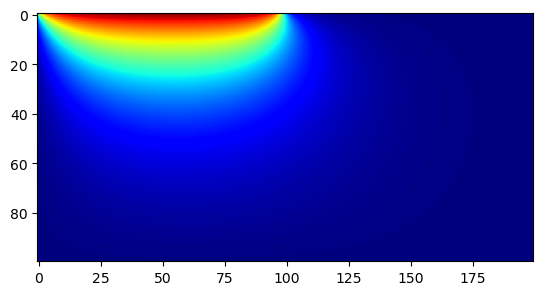

In [375]:
# Visualise final state
plt.imshow(Node_History[-1,1:-1,1:-1].T, cmap='jet')

#### Complex Boundary

In [376]:
# Initialise system
Nodes = np.zeros((nx+2, ny+2))    # add one for the boundaries on each side
Nodes = Enforce_Complex_Boundary(Nodes, int(nx/2))

# Propogate the system over time
Node_History_complex = np.zeros((nt, nx+2, ny+2))    # All nodes at all timesteps
Node_History_complex[0] = Nodes    # Store initial node

for n in tqdm(range(nt-1)):
    Node_History_complex[n+1] = Implicit_Timestep(Node_History_complex[n], A, nx, ny, Enforce_Complex_Boundary)

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:31<00:00, 16.00it/s]


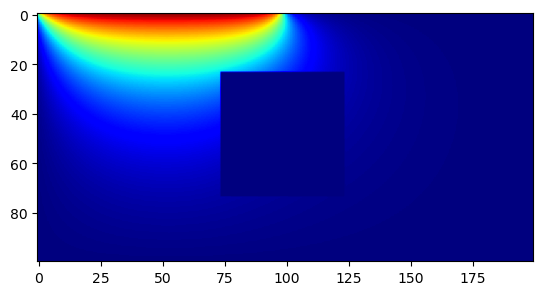

In [377]:
# Visualise final state
plt.imshow(Node_History_complex[-1,1:-1,1:-1].T, cmap='jet')

#### Temp at different y at Lx/2

In [378]:
def Plot_for_Lx_over_2(Node_History):
    '''
    Plots a few different y values at Lx/2
    '''
    # Get all time steps and y values for lx_over_2
    lx_over_2 = Node_History[:,int(nx/2),:]

    # Remove values from the boundaries
    lx_over_2 = lx_over_2[:,1:-1]

    # Get 5 evenly spaced samples
    lx_over_2_a = lx_over_2[:,0]
    lx_over_2_b = lx_over_2[:,33]
    lx_over_2_c = lx_over_2[:,66]
    lx_over_2_d = lx_over_2[:,99]

    # Plot them all
    plt.plot(lx_over_2_a, label='y=0')    
    plt.plot(lx_over_2_b, label='y=33')
    plt.plot(lx_over_2_c, label='y=66')
    plt.plot(lx_over_2_d, label='y=99')
    plt.legend(loc='lower right')

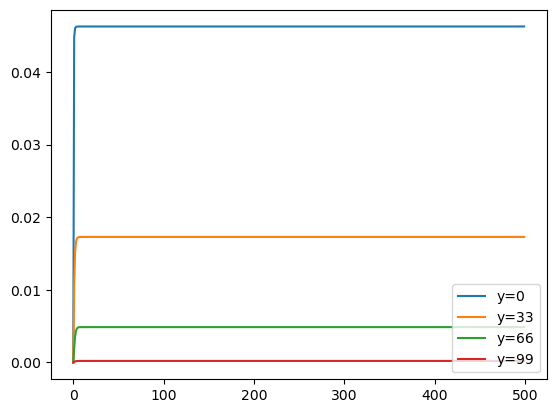

In [379]:
Plot_for_Lx_over_2(Node_History)

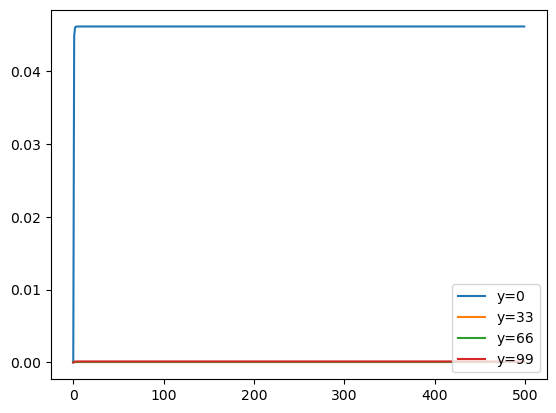

In [380]:
Plot_for_Lx_over_2(Node_History_complex)

#### Temp at different x at Ly/2

In [381]:
def Plot_for_Ly_over_2(Node_History):
    '''
    Plots a few different y values at Ly/2
    '''
    # Get all time steps and y values for ly_over_2
    ly_over_2 = Node_History[:,:,int(ny/2)]

    # Remove values from the boundaries
    ly_over_2 = ly_over_2[:,1:-1]

    # Get 5 evenly spaced samples
    ly_over_2_a = ly_over_2[:,0]
    ly_over_2_b = ly_over_2[:,66]
    ly_over_2_c = ly_over_2[:,133]
    ly_over_2_d = ly_over_2[:,199]

    # Plot them all
    plt.plot(ly_over_2_a, label='x=0')    
    plt.plot(ly_over_2_b, label='x=66')
    plt.plot(ly_over_2_c, label='x=133')
    plt.plot(ly_over_2_d, label='x=199')
    plt.legend(loc='lower right')

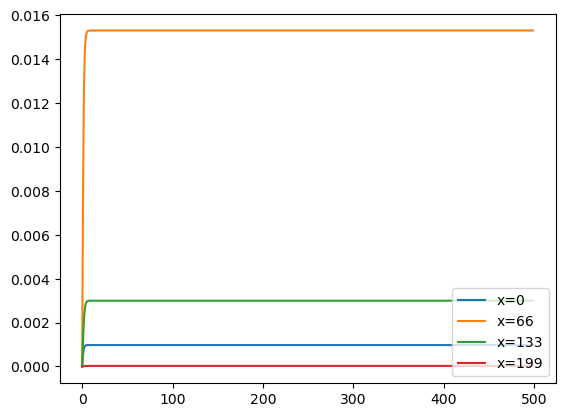

In [382]:
Plot_for_Ly_over_2(Node_History)

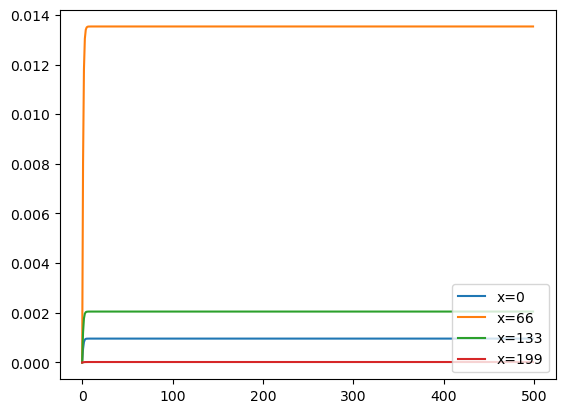

In [383]:
Plot_for_Ly_over_2(Node_History_complex)

#### Difference between plots

This plot shows where the panel without the hole is hotter than the pannel with the hole. It makes more sense with a color bar. The panel with the hole is warmer nowhere. It's cooler by most at the edges of the hole it seems. I'm not sure why, and it could just be an issue with the code as I'd almost expect the opposite, but I've never studied heat flows so have poor intuitions about it. 

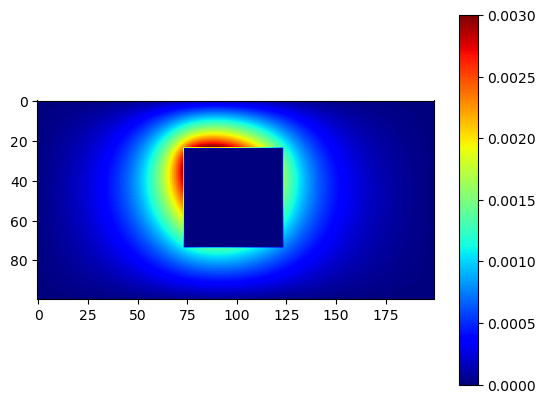

In [384]:
n = 50
difference = Node_History[n] - Node_History_complex[n]
difference = Enforce_Complex_Boundary(difference, int(nx/2))    # I'm doing this to set the "difference" inside the hole to 0, otherwise this dominates the plot and every other diff shows as 0

# visualise difference
plt.imshow(difference[1:-1,1:-1].T, cmap='jet')
plt.colorbar()
plt.show()